# Deteção de Fraude em Transações Ethereum

## Business Understanding

O objetivo deste projeto é desenvolver um modelo ML para detetar fraudes em transações Ethereum. A blockchain Ethereum processa milhares de transações diariamente, pelo que identificar transações fraudulentas em tempo real se torna um problema e um desafio significativo para a segurança da rede que precisa de ser resolvido.

### Objetivos
- **Identificar padrões de transações fraudulentas** no Ethereum para sinalizar atividades suspeitas.
- **Minimizar falsos positivos e falsos negativos**, já que transações legítimas classificadas como fraudulentas pode ter implicações/atritos, e fraudes classificadas incorretamente como legítimas podem causar perdas financeiras e vulnerabilidades do sistema.

### Métricas a ter em conta
1. **Precisão do Modelo**: precisão, recall, F1-score, AUC, etc. 
2. **Eficiência**: tempo de execução, recursos computacionais, etc.
3. **Viabilidade Operacional**: facilidade de implementação, interpretabilidade, aplicabilidade prática em tempo real, etc.

### Avaliação de Risco
- **Qualidade dos Dados**: dados de transações Ethereum são altamente voláteis e complexos, com muitos fatores a considerar. Podem conter erros, valores inconsistentes, valores em falta, etc.
- **Regulamentação**: a deteção de fraudes em transações Ethereum pode estar sujeita a regulamentações e leis de privacidade de dados.
- **Impacto Financeiro**: qual será o impacto financeiro de falsos positivos e falsos negativos? Como podemos minimizar esses impactos?

## Data Understanding
Para entender os dados, vamos carregar o dataset e explorar as suas características.

### Estrutura do Dataset
O dataset tem as seguintes colunas:
- `TxHash`: Id exclusivo de cada transação.
- `BlockHeight`: número do bloco onde a transação foi incluída.
- `TimeStamp`: data e hora da transação.
- `From`: endereço Ethereum do remetente.
- `To`: endereço Ethereum do destinatário.
- `Value`: quantidade de Ether transferida.
- `isError`: indicador de erro na transação (0 = sem erro, 1 = com erro).



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import torch

# Verificar se há CUDA disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configurar opções de visualização
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
fo_df = pd.read_csv('dataset/first_order_df.csv')
fo_df.head()

,Unnamed: 0,TxHash,BlockHeight,TimeStamp,From,To,Value,isError
0,0,0xaca3850ba0080cf47b47f80e46da452f61bcbb5470d3...,5848095,1529873859,0x16f209b5332a1b4fa5bf19497ca40154c5db2f85,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.500000,0
1,1,0x95681862f9778e49caecf603dd911d6ed57f7799d89d...,5848181,1529875104,0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.001020,0
2,2,0x716ae3961b50186a0bbc272cfcc4555662f7fe33550f...,5848716,1529883192,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.500390,0
3,3,0xf397197b800d6cc055a4db265b5e9df3dd2aa745c813...,5849038,1529887684,0x0681d8db095565fe8a346fa0277bffde9c0edbbf,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.817800,0
4,4,0x7f8086011a32f128dba57fe06fc5f4a181d2f5401e5a...,5849437,1529893144,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.817506,0


In [5]:
fo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254973 entries, 0 to 254972
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   254973 non-null  int64  
 1   TxHash       254973 non-null  object 
 2   BlockHeight  254973 non-null  int64  
 3   TimeStamp    254973 non-null  int64  
 4   From         254973 non-null  object 
 5   To           254642 non-null  object 
 6   Value        254973 non-null  float64
 7   isError      254973 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 15.6+ MB


Ao verificar informações gerais do dataset, percebe-se que existe uma coluna `Unnamed: 0` que não possui informações relevantes para a análise. Portanto, será removida.

In [6]:
fo_df.drop(['Unnamed: 0'], axis=1, inplace=True)
fo_df

,TxHash,BlockHeight,TimeStamp,From,To,Value,isError
0,0xaca3850ba0080cf47b47f80e46da452f61bcbb5470d3...,5848095,1529873859,0x16f209b5332a1b4fa5bf19497ca40154c5db2f85,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.500000,0
1,0x95681862f9778e49caecf603dd911d6ed57f7799d89d...,5848181,1529875104,0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.001020,0
2,0x716ae3961b50186a0bbc272cfcc4555662f7fe33550f...,5848716,1529883192,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.500390,0
3,0xf397197b800d6cc055a4db265b5e9df3dd2aa745c813...,5849038,1529887684,0x0681d8db095565fe8a346fa0277bffde9c0edbbf,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.817800,0
4,0x7f8086011a32f128dba57fe06fc5f4a181d2f5401e5a...,5849437,1529893144,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.817506,0
...,...,...,...,...,...,...,...
254968,0xefbdb95e7e0dae4f83f975a44c7ccf7e6b027131969e...,6101678,1533603040,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0x725d0607775d6e8e85136e51808b9492e39d217d,0.700000,0
254969,0x37c0af73723405236804486c835282a1971e08a45a11...,6104069,1533638323,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0x5d63c7b81aaa63d2df376c0bc6197ab5132e94e7,0.770000,0
254970,0xdd193f8d9ebf7eecd3ad59192a807b420e3a5d38ff1a...,6104111,1533639008,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0x1219320139334c3d79aae0507a2aa9e278935665,0.500000,0
254971,0x1b3329bdb6c8d6a817ebe55bfd6434ece5cb23817b0d...,6104810,1533649370,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0xf3702667fb827bd9c675b88187e9a764b5dc9d40,0.330000,0


Há dados nulos? Há dados duplicados? Qual é a distribuição dos dados?

In [7]:
print(fo_df.isnull().sum())

fo_df.describe()

TxHash           0
BlockHeight      0
TimeStamp        0
From             0
To             331
Value            0
isError          0
dtype: int64


,BlockHeight,TimeStamp,Value,isError
count,2.549730e+05,2.549730e+05,254973.000000,254973.000000
mean,5.391963e+06,1.522941e+09,4.784175,0.061316
std,7.332419e+05,1.107530e+07,207.403848,0.239910
min,2.722620e+06,1.480521e+09,0.000000,0.000000
25%,4.908133e+06,1.515950e+09,0.000000,0.000000
50%,5.356399e+06,1.522521e+09,0.012500,0.000000
75%,5.855385e+06,1.529985e+09,0.500000,0.000000
max,7.781130e+06,1.558142e+09,25533.614518,1.000000


Há 254,973 entradas no dataset. Algumas coisas a destacar:
- A coluna `To` tem 331 valores nulos. Vamos verificar.
- O valor médio das transações é de 4,78 Ethereum.
- A transação mais cara foi de 25533 Ethereum.
- Existem transações com o valor de 0 Ethereum.

In [8]:

count_isError = 0
count_notIsError = 0

for index, row in fo_df[fo_df['To'].isnull()].iterrows():
    if row['isError'] == 1:
        count_isError += 1
    else:
        count_notIsError += 1

print('isError:', count_isError)
print('notIsError:', count_notIsError)
    

isError: 3
notIsError: 328


Dos 331 valores nulos, apenas 3 são de erro, pelo que provavelmente não teremos problemas em remover esses valores. Além de representarem apenas uma pequeníssima percentagem do número total de dados, parece que não há grande relação entre o facto de a coluna `To` estar nula e a coluna `isError` ser 1.

In [9]:
filtered_fo_df = fo_df.dropna(subset=['To'])

### Análise da variável `isError`
A variável `isError` é o alvo da nossa análise, onde `0` indica que a transação foi realizada sem erro e `1` indica um erro (possivelmente fraude). Vamos examinar a distribuição dessa variável.

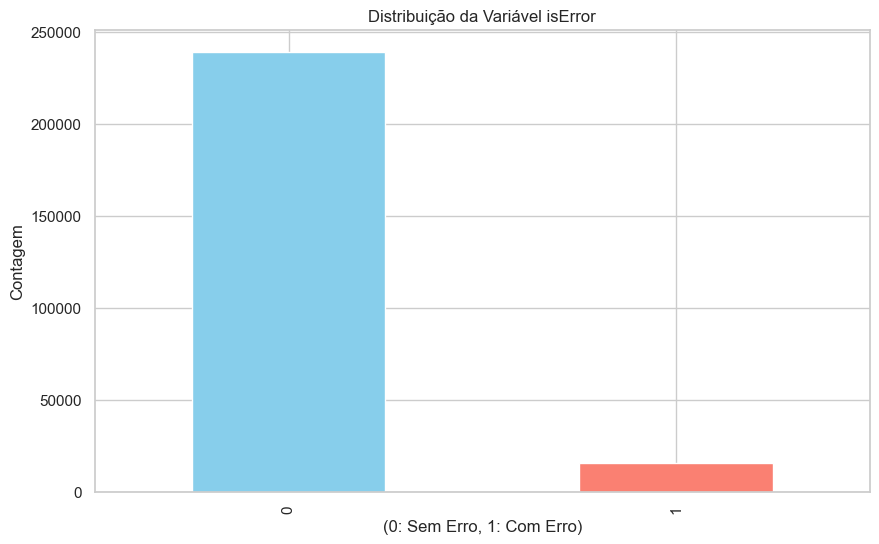

isError
0    93.861578
1     6.138422
Name: proportion, dtype: float64

In [10]:
filtered_fo_df['isError'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribuição da Variável isError')
plt.xlabel('(0: Sem Erro, 1: Com Erro)')
plt.ylabel('Contagem')
plt.show()


filtered_fo_df['isError'].value_counts(normalize=True) * 100

A target variable `isError` é desbalanceada, com 93,86% das transações sem erro e 6,1% com erro.

### Análise da Variável `Value`
A variável `Value`, que representa a quantidade de Ether transferida, pode ser um indicativo de transações suspeitas.

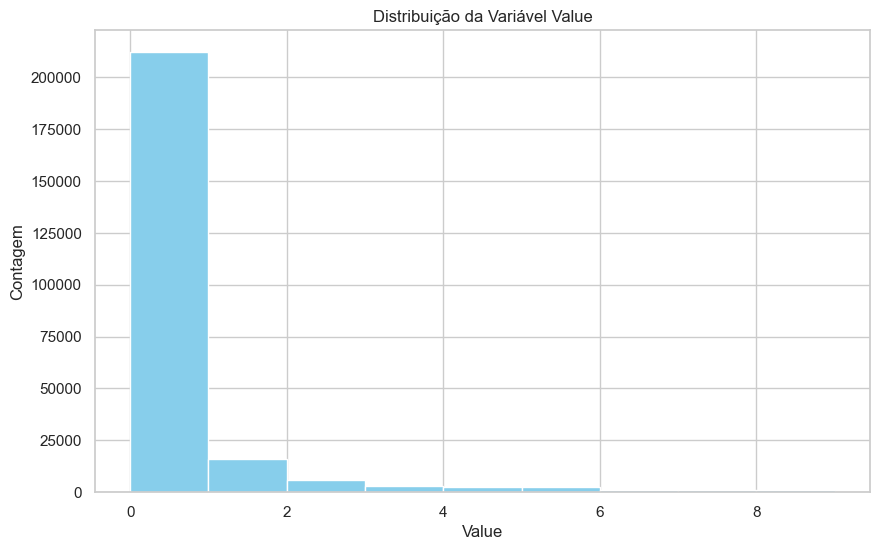

In [11]:
# Distribuição da variável Value, com steps de 1 no eixo x
filtered_fo_df['Value'].plot(kind='hist', bins=range(0, 10, 1), color='skyblue')
plt.title('Distribuição da Variável Value')
plt.xlabel('Value')
plt.ylabel('Contagem')
plt.show()

Consegue-se ver que há muitas entradas cujo valor transacionado é 0. No contexto de transações em Ethereum, é possível que representem:
- Transações de contrato inteligente (smart contract) que não envolvem transferência de Ether, tipo NFTs, DeFi.
- Transações de teste.
- Transações fraudulentas.

Pode-se verificar a coluna `isError` nas transações com valor 0 para ver se há alguma relação.

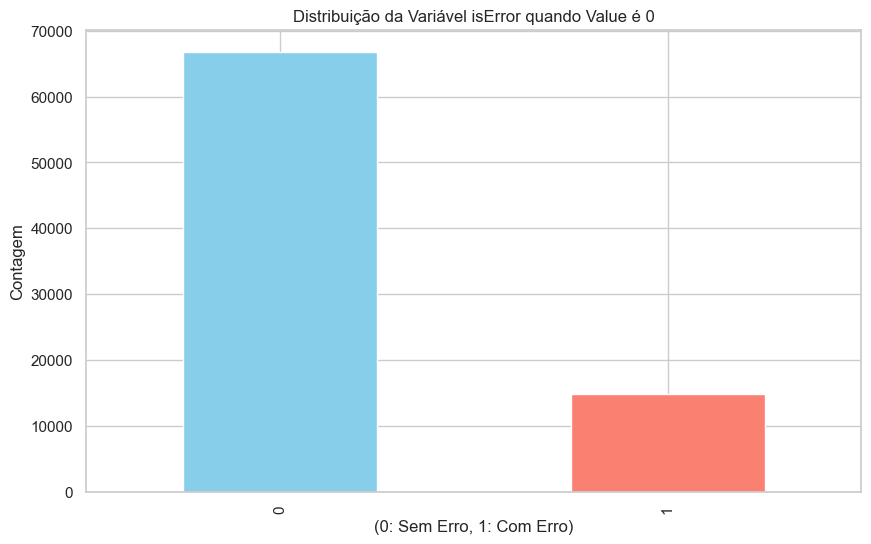

In [12]:
# print when value is 0
trans_value_0 = filtered_fo_df[filtered_fo_df['Value'] == 0]

trans_value_0.head()


trans_value_0['isError'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribuição da Variável isError quando Value é 0')
plt.xlabel('(0: Sem Erro, 1: Com Erro)')
plt.ylabel('Contagem') 
plt.show()


### Correlação entre as variáveis

Normalmente, faria a correlação entre variáveis para analisar se existe relação entre as variáveis e a variável alvo. No entanto, tirando as variáveis categóricas, ficariamos apenas com as variáveis `Value`, `BlockHeight` e `Timestamp`. Pelo contexto em questão, provavelmente a matriz de correlaçao não seria muito útil, mas vamos verificar.

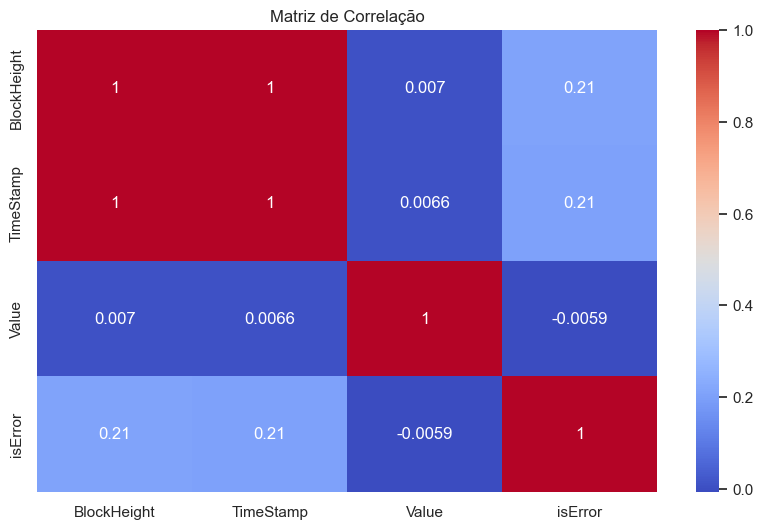

In [13]:
df_numeric = filtered_fo_df.select_dtypes(include=['float64', 'int64'])

correlation = df_numeric.corr()

sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

`BlockHeight` e `Timestamp` estão diretamente relacionadas entre si, o que é natural pois a blockchain é uma sequência de blocos, e cada bloco é adicionado à blockchain num intervalo de tempo.

Agora, para otimizar a análise e melhorar a qualidade dos dados, aplicamos um filtro que limita os endereços considerados no conjunto de dados. Este processo de filtragem visa incluir apenas contas com uma atividade significativa, definida como aquelas que têm entre 4 e 500 transações. Esta abordagem traz várias vantagens:

1. **Foco em Contas Ativas**:
   - Endereços com menos de 5 transações são mais inativos, representando atividade mínimak, podendo introduzir ruído nos dados. Por outro lado, endereços com mais de 500 transações costumam ser exchanges ou contratos inteligentes muito populares, que podem não ser relevantes para análises de fraude direcionadas a contas de menor visibilidade.

2. **Melhoria de Desempenho Computacional**:
   - Em datasets grandes, limitar o número de contas a analisar é essencial para manter o tempo de execução e o uso de memória dentro de parâmetros razoáveis, especialmente ao criar grafos de relação entre carteiras.

3. **Potencial Detecção de Fraudes em Padrões Menos Óbvios**:
   - Contas com atividade moderada, mas consistente, são mais propensas a padrões de fraude discreta, enquanto contas altamente ativas geralmente estão mais expostas e são de entidades conhecidas.

In [14]:
# Obter contagens totais de transações para cada endereço
from_counts = filtered_fo_df['From'].value_counts()
to_counts = filtered_fo_df['To'].value_counts()

# Somar as contagens de 'From' e 'To' para obter uma contagem combinada
combined_counts = from_counts.add(to_counts, fill_value=0)

# Filtrar endereços com transações entre 5 e 500
filtered_counts = combined_counts.loc[(combined_counts >= 5) & (combined_counts <= 500)]

# Selecionar apenas transações que envolvem os endereços filtrados
values_to_keep = filtered_counts.index.tolist()
filtered_df = filtered_fo_df[filtered_fo_df['From'].isin(values_to_keep) & filtered_fo_df['To'].isin(values_to_keep)]

# Resetar o índice do DataFrame filtrado
filtered_df = filtered_df.reset_index(drop=True)
filtered_df


,TxHash,BlockHeight,TimeStamp,From,To,Value,isError
0,0x716ae3961b50186a0bbc272cfcc4555662f7fe33550f...,5848716,1529883192,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.500390,0
1,0x7f8086011a32f128dba57fe06fc5f4a181d2f5401e5a...,5849437,1529893144,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.817506,0
2,0xb8a7330af45b7be8155e4ffe437110ce912cb7986632...,4981935,1517057137,0xcbb240ad8beb648773d78d966caaee46d45add3a,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0.002305,0
3,0xd3e26b0a15a76c1fda5ee297924c7a46b75811588fb3...,4982190,1517060992,0xc90873d0c4b07db2327676d3b3f2add807d5fc0e,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0.014261,0
4,0xf1df92e16295368daf93e3cf793359f6ba8ef2d3e2e5...,4982642,1517067252,0xfffa5f2b2cb0b916ef69cc23cacf02f34abd0a79,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0.008121,0
...,...,...,...,...,...,...,...
43537,0x020f75601c9fc8a5029a65c492e5753cda3a3a20efdc...,6064839,1533065124,0x2a4127e646f0ec5d39d604d9085a88296049d337,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0.068800,0
43538,0x6da824b9a5b3e5f1e416a4a5f58cec67375e89d21e88...,6064851,1533065246,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0x2a4127e646f0ec5d39d604d9085a88296049d337,0.229000,0
43539,0x40dfa46e27534c52c174e3f2c503677d546ce03b6406...,6064861,1533065387,0x2a4127e646f0ec5d39d604d9085a88296049d337,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0.228910,0
43540,0xbd0352624b75713beaa77116e5ac1271b44f87d70d46...,6064872,1533065544,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0x2a4127e646f0ec5d39d604d9085a88296049d337,0.025000,0


In [15]:
import random
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

# Criação de um grafo direcionado
graph = nx.DiGraph()

print(len(filtered_df))

# Adicionar nós ao grafo
for i in range(len(filtered_df)):
  graph.add_edge(filtered_df['From'][i],filtered_df['To'][i])

43542


## Feature Engineering

Com as representações vetoriais dos endereços Ethereum, podemos criar features adicionais para detetar fraudes em transações Ethereum. Algumas features que podemos criar incluem:

1. **Total Degree (Grau Total)**
   - O grau total de um nó representa o número total de conexões (arestas) com outros nós, independentemente de serem transações de entrada ou saída.
   - **Importância:** Um nó com um grau total elevado pode ser considerado altamente interativo, indicando que ele está envolvido em muitas transações. Esse tipo de nó pode representar uma conta central ou muito ativa dentro da rede. Um grau total anormalmente alto pode também ser um indicativo de manipulação ou atividade suspeita.

2. **Out-Degree (Grau de Saída)**
   - O grau de saída se refere ao número de transações enviadas por um nó para outros nós.
   - **Importância:** Esse valor é importante para identificar nós que estão dispersando ativos. Se um nó tem um grau de saída muito alto, isso pode sugerir tentativas de dispersar os valores para ocultar sua origem ou, em contextos fraudulentos, para realizar lavagem de dinheiro.

3. **In-Degree (Grau de Entrada)**
   - O grau de entrada mede o número de transações recebidas por um nó de outros nós.
   - **Importância:** Um grau de entrada elevado pode indicar que o nó está acumulando grandes quantidades de recursos. Isso pode ser característico de nós que recebem muitos depósitos ou transferências, mas que não realizam muitas transações em troca, o que pode ser um comportamento suspeito.

4. **Out-Degree Ratio (Rácio de Grau de Saída)**
   - O rácio de grau de saída é a razão entre o grau de saída e o grau de entrada de um nó.
   - **Importância:** Esse rácio pode indicar o comportamento de dispersão de um nó. Se o valor for alto, pode significar que o nó está enviando grandes quantidades de recursos, o que pode ser característico de tentativas de dispersar recursos ou ocultar a origem dos mesmos.

5. **In-Degree Ratio (Rácio de Grau de Entrada)**
   - O rácio de grau de entrada é a razão entre o grau de entrada e o grau de saída de um nó.
   - **Importância:** Esse valor pode revelar a tendência de um nó em ser mais receptor do que emissor de transações. Um rácio elevado pode indicar que o nó está acumulando recursos e pode ser um comportamento típico de nós envolvidos em fraudes ou lavagem de dinheiro, que buscam acumular ativos sem dispersá-los.

6. **Sum of Transactions (Soma das Transações)**
   - A soma das transações é o valor total transacionado por um nó, incluindo tanto transações de entrada quanto de saída.
   - **Importância:** A soma total das transações é um bom indicador da quantidade de valor envolvido com o nó. Se um nó movimenta grandes quantidades de ativos, isso pode ser um indicativo de sua relevância na rede, mas também de atividade fraudulenta, caso o volume de transações não corresponda à atividade normal esperada.

7. **Transfer-Out Transaction (Transação de Saída)**
   - A transação de saída é a soma dos valores das transações enviadas pelo nó.
   - **Importância:** Esse valor é relevante para identificar nós que estão enviando grandes quantidades de recursos para outros nós. Esse comportamento pode ser um sinal de dispersão de ativos para outras contas, o que pode ser um padrão típico de lavagem de dinheiro.

8. **Transfer-In Transaction (Transação de Entrada)**
   - A transação de entrada representa a soma dos valores recebidos por um nó de outros nós.
   - **Importância:** A quantidade de transações de entrada ajuda a entender o papel do nó na rede, seja como receptor de recursos ou como acumulador de ativos. Um número alto de transações de entrada pode indicar um comportamento suspeito se não houver uma correspondência com transações de saída, sugerindo que o nó pode ser utilizado para acumular recursos de forma anormal.

9. **Transaction Difference (Diferença de Transações)**
   - A diferença de transações é a diferença entre a soma das transações de entrada e saída de um nó.
   - **Importância:** Esse valor revela se um nó é um "acumulador" (mais entradas do que saídas) ou um "dispersor" (mais saídas do que entradas). Uma diferença positiva pode indicar um nó acumulando recursos, enquanto uma diferença negativa pode sugerir que o nó está enviando grandes quantidades de ativos.

10. **Transaction Ratio (Rácio de Transações)**
    - O rácio de transações é a razão entre as transações de entrada e saída de um nó.
    - **Importância:** Esse rácio pode ajudar a entender o equilíbrio entre as transações de entrada e saída de um nó. Se um nó tem um rácio muito alto, isso pode indicar que ele está mais focado em receber recursos do que em enviar, o que pode ser um comportamento anômalo dependendo do contexto.

11. **Transfer-In Ratio (Rácio de Entrada)**
    - O rácio de entrada é a razão entre as transações de entrada e o grau de entrada de um nó.
    - **Importância:** Esse valor pode indicar se o nó está recebendo mais recursos do que seria esperado com base na sua interação com outros nós. Isso pode sugerir que o nó está acumulando recursos de forma incomum, o que é um comportamento que merece atenção, especialmente em análises de fraudes.

12. **Transfer-Out Ratio (Rácio de Saída)**
    - O rácio de saída é a razão entre as transações de saída e o grau de saída de um nó.
    - **Importância:** Esse rácio pode revelar se o nó está tentando enviar recursos de forma mais ativa em comparação ao seu grau de interação com outros nós. Esse comportamento pode ser uma forma de dispersar valores rapidamente, uma prática comum em atividades fraudulentas.

13. **Number of Neighbours (Número de Vizinhos)**
    - O número de vizinhos representa a quantidade de nós diretamente conectados ao nó em questão.
    - **Importância:** Esse valor é importante para entender a centralidade de um nó dentro da rede. Nós com muitos vizinhos podem ser considerados nós centrais e essenciais, enquanto nós com poucos vizinhos podem ser menos relevantes. A quantidade de vizinhos também pode ajudar a identificar padrões de agrupamento ou isolamento dentro da rede.

14. **Inverse Timestamp Frequency (Frequência Inversa do Timestamp)**
    - A frequência inversa do timestamp calcula a frequência média das transações de um nó com base na diferença entre os timestamps das transações.
    - **Importância:** Uma frequência alta de transações (ou uma diferença de tempo pequena entre elas) pode indicar um nó com atividades suspeitas ou um padrão anômalo de comportamento, como tentativas de mover grandes quantidades de recursos rapidamente.


In [ ]:
# Criar as features
def compute_graph_features(graph, df):
    features = []
    for node in graph.nodes:
        in_degree = graph.in_degree(node)
        out_degree = graph.out_degree(node)
        total_degree = in_degree + out_degree
        in_value = df[df['To'] == node]['Value'].sum()
        out_value = df[df['From'] == node]['Value'].sum()
        sum_transactions = in_value + out_value
        transaction_diff = in_value - out_value

        # Calcular rácios, evitando divisões por zero
        out_degree_ratio = out_degree / (in_degree + 1)
        in_degree_ratio = in_degree / (out_degree + 1)
        transaction_ratio = in_value / (out_value + 1)
        transfer_in_ratio = in_value / (in_degree + 1)
        transfer_out_ratio = out_value / (out_degree + 1)
        
        timestamp_diff = ((filtered_df.loc[filtered_df['From'] == node, 'TimeStamp'].diff()).sum() + (filtered_df.loc[filtered_df['To'] == node, 'TimeStamp'].diff()).sum())
        avg_timestamp_diff = timestamp_diff/(len(filtered_df.loc[filtered_df['From'] == node, 'TimeStamp'])+len(filtered_df.loc[filtered_df['To'] == node, 'TimeStamp']))
        if avg_timestamp_diff == 0:
            inv_timestamp_freq = 0
        else :
            inv_timestamp_freq = 1/avg_timestamp_diff
        
        features.append([
            total_degree, out_degree, in_degree,
            in_value, out_value, sum_transactions,
            transaction_diff, out_degree_ratio,
            in_degree_ratio, transaction_ratio,
            transfer_in_ratio, transfer_out_ratio,
            inv_timestamp_freq
        ])

    return np.array(features)

# Calcular features
features = compute_graph_features(graph, filtered_df)
features

SyntaxError: invalid syntax (1430063566.py, line 26)

In [17]:
from tqdm import tqdm

nodes_list = list(graph.nodes())
result_data = []

for node in tqdm(nodes_list):
    is_error_value = int(any(fo_df[fo_df['From'] == node]['isError'] == 1) or any(fo_df[fo_df['To'] == node]['isError'] == 1))
    result_data.append((node, is_error_value))

result_df = pd.DataFrame(result_data, columns=['Node', 'isError'])
result_df

  0%|          | 0/4870 [00:00<?, ?it/s]

100%|██████████| 4870/4870 [02:48<00:00, 28.95it/s]


,Node,isError
0,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0
1,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0
2,0xcbb240ad8beb648773d78d966caaee46d45add3a,0
3,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,1
4,0xc90873d0c4b07db2327676d3b3f2add807d5fc0e,0
...,...,...
4865,0xa4940f812907115c1d63c5ec998dd195732cb285,0
4866,0xfe5abe24fe9de5fa1a3e6d433bddf1278dfa652f,0
4867,0x117f674866a87ee44db7bccdb298298aa58229ac,0
4868,0xef0e4d16722aeedce4d4f2ca7a16697f5613bfd3,0


In [18]:
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.data import Data

# Normalizar as features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)

# Criar uma matriz de adjacência
adj_matrix = nx.adjacency_matrix(graph)
adj_matrix

labels = result_df['isError'].values
labels

node_mapping = {node: idx for idx, node in enumerate(graph.nodes)}
node_mapping


from_nodes = filtered_df['From'].values
to_nodes = filtered_df['To'].values

# criar edge index
edge_index = np.array([[node_mapping[from_node], node_mapping[to_node]] for from_node, to_node in zip(from_nodes, to_nodes)])

from sklearn.model_selection import train_test_split

# Criar objeto de dados para PyTorch Geometric
data = Data(
    x=torch.tensor(normalized_features, dtype=torch.float),
    edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
    y=torch.tensor(labels, dtype=torch.long)
)
data

c:\Users\maysa\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Data(x=[4870, 13], edge_index=[2, 43542], y=[4870])

Para cada nó (endereço Ethereum) no grafo, vamos guardar num dataframe se esse nó já esteve envolvido em transações fraudulentas ou não. Este dataframe será usado para treinar o modelo.

In [19]:
import torch
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class GraphModel(torch.nn.Module):
    def __init__(self, node_in_channels, hidden_channels, num_heads):
        super().__init__()
        # GAT convolutions
        self.conv1 = GATConv(node_in_channels, hidden_channels, heads=num_heads)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads)
        
        # Batch normalization and dropout
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels * num_heads)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels * num_heads)
        self.dropout = torch.nn.Dropout(0.3)
        
        # Classification layer
        self.classifier = torch.nn.Linear(hidden_channels * num_heads, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # GAT propagation
        out = self.conv1(x, edge_index)
        out = F.relu(out)
        out = self.bn1(out)
        out = self.dropout(out)
        
        out = self.conv2(out, edge_index)
        out = F.relu(out)
        out = self.bn2(out)
        out = self.dropout(out)
        
        # Classification
        out = self.classifier(out)
        return out

    def get_node_embeddings(self, data):
        x, edge_index = data.x, data.edge_index
        
        # GAT propagation for embeddings
        out = self.conv1(x, edge_index)
        out = F.relu(out)
        out = self.bn1(out)
        out = self.dropout(out)
        
        out = self.conv2(out, edge_index)
        out = F.relu(out)
        out = self.bn2(out)
        out = self.dropout(out)
        
        return out.detach()

In [20]:
from sklearn.model_selection import train_test_split

# Primeiro, divida os dados em treino e teste
train_idx, test_idx = train_test_split(
    np.arange(len(labels)),
    test_size=0.2,
    random_state=42,
    stratify=labels  # Manter a proporção de classes
)

# Depois, divida o conjunto de teste em validação e teste
val_idx, test_idx = train_test_split(
    test_idx,
    test_size=0.5,
    random_state=42,
    stratify=labels[test_idx]  # Manter a proporção de classes no conjunto de teste
)

# Criar máscaras para os índices de treino, validação e teste
train_mask = torch.zeros(len(labels), dtype=torch.bool)
val_mask = torch.zeros(len(labels), dtype=torch.bool)
test_mask = torch.zeros(len(labels), dtype=torch.bool)

# Definir os índices de treino, validação e teste como True nas máscaras
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True


In [21]:
# Criar o modelo
node_in_channels = normalized_features.shape[1]
hidden_channels = 16
num_heads = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GraphModel(node_in_channels, hidden_channels, num_heads).to(device)

# Definir função de perda e otimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses = []
val_losses = []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.to(device))
    loss = criterion(out[train_mask], data.y[train_mask])
    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    # validar o modelo
    model.eval()
    with torch.no_grad():
        logits = model(data.to(device))
        val_loss = criterion(logits[val_mask], data.y[val_mask])
        val_losses.append(val_loss.item())
        pred = logits[val_mask].max(1)[1]
        print("pred: ", pred)
        acc = pred.eq(data.y[val_mask]).sum().item() / val_mask.sum().item()
        #print(f'Epoch: {epoch}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {acc:.4f}')
    
    if epoch > 10 and val_loss > 0.9:
        print('Early stopping')
        break
    
model.eval()
with torch.no_grad():
    logits = model(data.to(device))
    test_loss = criterion(logits[test_mask], data.y[test_mask])
    pred = logits[test_mask].max(1)[1]
    acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
    print(f'Test Loss: {test_loss.item():.4f}, Test Acc: {acc:.4f}')

# Calcular métricas de avaliação
precision = precision_score(data.y[test_mask].cpu(), pred.cpu())
recall = recall_score(data.y[test_mask].cpu(), pred.cpu())
f1 = f1_score(data.y[test_mask].cpu(), pred.cpu())

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')


pred:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0

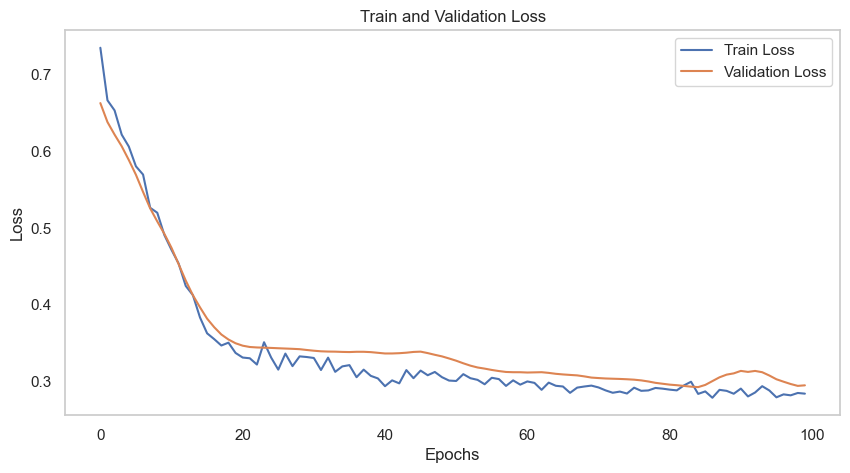

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid()
plt.show()

Para cada nó (endereço Ethereum) no grafo, vamos guardar num dataframe se esse nó já esteve envolvido em transações fraudulentas ou não. Este dataframe será usado para treinar o modelo.

In [23]:
import optuna
import torch
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

def objective_gnn(trial):
    # Sugerir hiperparâmetros para otimização
    hidden_channels = trial.suggest_int('hidden_channels', 64, 256, step=64) # hipermarametro é 
    num_heads = trial.suggest_int('num_heads', 2, 8)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

    # Criar o modelo com os hiperparâmetros sugeridos
    model = GraphModel(
        node_in_channels=data.x.size(-1),
        hidden_channels=hidden_channels,
        num_heads=num_heads
    ).to(device)

    # Inicializar o otimizador e a função de perda
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    early_stopping_patience = 20
    best_val_loss = float('inf')  # Inicializa com infinito
    patience_counter = 0

    for epoch in range(300):
        model.train()
        optimizer.zero_grad()
        out = model(data.to(device))
        loss = criterion(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()

        # Validar o modelo
        model.eval()
        with torch.no_grad():
            logits = model(data.to(device))
            val_loss = criterion(logits[val_mask], data.y[val_mask])
            
            # Early stopping baseado na validação
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter > early_stopping_patience:
                print(f'Early stopping on epoch {epoch}')
                break

            
            pred = logits[val_mask].max(1)[1]  # Predições
            val_f1 = f1_score(data.y[val_mask].cpu(), pred.cpu(), average='macro')  # Macro F1 para multi-classes

            
    return val_f1

# Criar o estudo do Optuna para otimizar a função objective_gnn
study_gnn = optuna.create_study(direction='maximize')
study_gnn.optimize(objective_gnn, n_trials=10)  # Realizar 10 tentativas de otimização

# Exibir os melhores hiperparâmetros encontrados
print(f"Melhores hiperparâmetros encontrados: {study_gnn.best_params}")


[I 2024-11-26 11:21:09,848] A new study created in memory with name: no-name-cf839dd1-a48a-48da-ac07-40156b2c6326
[I 2024-11-26 11:21:11,596] Trial 0 finished with value: 0.09981515711645102 and parameters: {'hidden_channels': 192, 'num_heads': 6, 'lr': 0.0002798485840499743}. Best is trial 0 with value: 0.09981515711645102.


Early stopping on epoch 21


[I 2024-11-26 11:21:21,390] Trial 1 finished with value: 0.6842056507642427 and parameters: {'hidden_channels': 128, 'num_heads': 8, 'lr': 0.0006304150833228713}. Best is trial 1 with value: 0.6842056507642427.


Early stopping on epoch 145


[I 2024-11-26 11:21:26,140] Trial 2 finished with value: 0.5579698064277114 and parameters: {'hidden_channels': 64, 'num_heads': 7, 'lr': 0.004266590848727774}. Best is trial 1 with value: 0.6842056507642427.


Early stopping on epoch 130


[I 2024-11-26 11:21:32,798] Trial 3 finished with value: 0.6251573352168283 and parameters: {'hidden_channels': 192, 'num_heads': 6, 'lr': 0.00017047336627746127}. Best is trial 1 with value: 0.6842056507642427.


Early stopping on epoch 80


[I 2024-11-26 11:21:34,077] Trial 4 finished with value: 0.09981515711645102 and parameters: {'hidden_channels': 128, 'num_heads': 5, 'lr': 0.0007567556416470019}. Best is trial 1 with value: 0.6842056507642427.


Early stopping on epoch 26


[I 2024-11-26 11:21:35,766] Trial 5 finished with value: 0.4706521739130435 and parameters: {'hidden_channels': 192, 'num_heads': 2, 'lr': 0.008293915429572002}. Best is trial 1 with value: 0.6842056507642427.


Early stopping on epoch 54


[I 2024-11-26 11:21:47,910] Trial 6 finished with value: 0.5822220142560791 and parameters: {'hidden_channels': 256, 'num_heads': 5, 'lr': 0.0010264861865586265}. Best is trial 1 with value: 0.6842056507642427.


Early stopping on epoch 125


[I 2024-11-26 11:21:54,874] Trial 7 finished with value: 0.5822220142560791 and parameters: {'hidden_channels': 64, 'num_heads': 4, 'lr': 0.0005314182852286978}. Best is trial 1 with value: 0.6842056507642427.


Early stopping on epoch 286


[I 2024-11-26 11:21:57,683] Trial 8 finished with value: 0.5731398519672769 and parameters: {'hidden_channels': 64, 'num_heads': 3, 'lr': 0.005447998143673449}. Best is trial 1 with value: 0.6842056507642427.


Early stopping on epoch 125


[I 2024-11-26 11:22:00,225] Trial 9 finished with value: 0.6099319183019624 and parameters: {'hidden_channels': 128, 'num_heads': 2, 'lr': 0.008728376931864894}. Best is trial 1 with value: 0.6842056507642427.


Early stopping on epoch 104
Melhores hiperparâmetros encontrados: {'hidden_channels': 128, 'num_heads': 8, 'lr': 0.0006304150833228713}


54
54
54
54
97
430
432
432
432
426
361
54
54
54
54
54
54
55
59
67
74
106
406
421
422
423
423
424
425
430
431
432
433
433
433
432
431
431
431
432
432
433
434
434
433
433
433
434
434
434
434
433
433
433
433
433
433
434
434
434
434
434
434
434
434
434
434
434
434
434
434
435
434
435
434
434
429
433
434
436
436
436
435
435
435
435
435
436
433
433
433
432
431
430
426
434
436
435
439
439
438
435
434
437
436
434
434
435
432
428
428
427
426
437
437
436
435
434
430
427
426
427
434
436
433
429
427
426
434
437
436
436
434
436
429
429
428
427
427
431
433
435
436
432
425
425
427
433
437
434
436
431
430
429
Early stopping on epoch 153


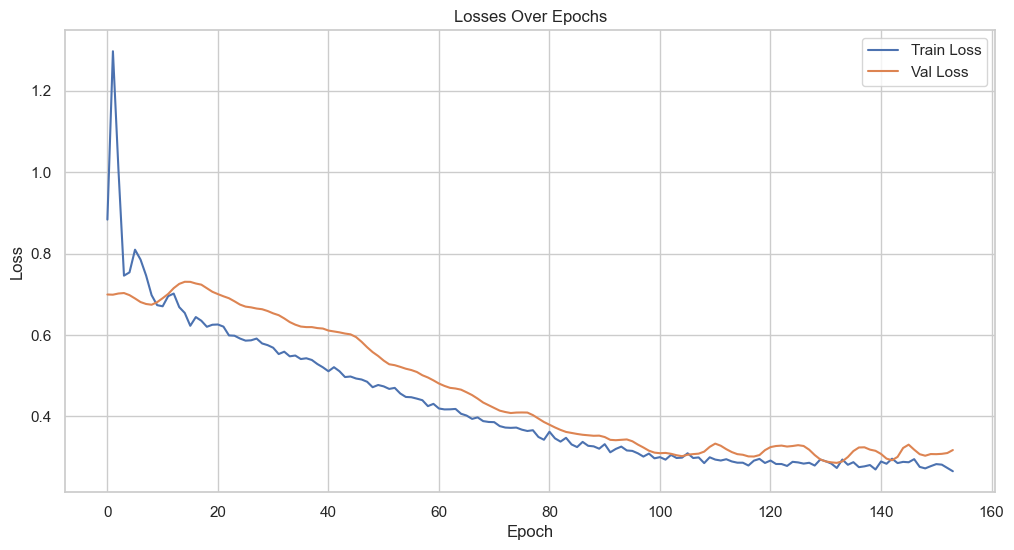

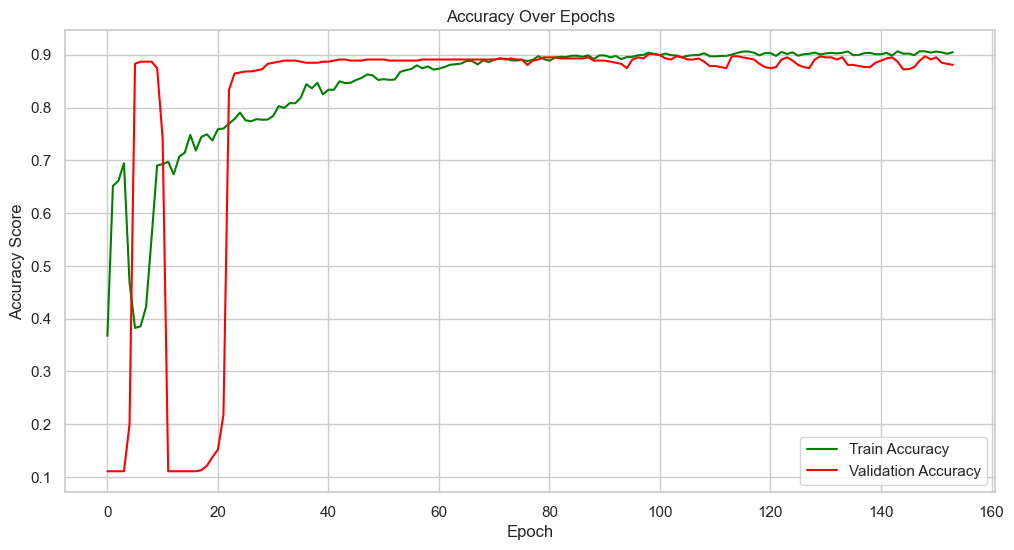

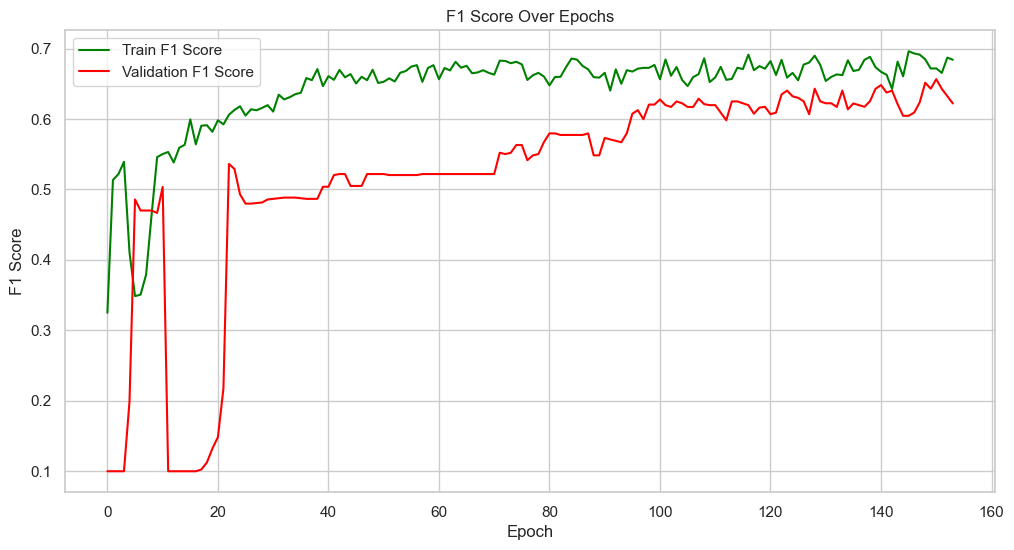

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Set the best hyperparameters for the new model
hidden_channels = study_gnn.best_params['hidden_channels']
num_heads = study_gnn.best_params['num_heads']
lr = study_gnn.best_params['lr']

# Create a new model with the best hyperparameters
model = GraphModel(
    node_in_channels=data.x.size(-1),
    hidden_channels=hidden_channels,
    num_heads=num_heads
).to(device)

# Initialize the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

# Early stopping parameters
early_stopping_patience = 20
best_val_loss = float('inf')  # Inicializa com infinito
patience_counter = 0

# Training the model
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_f1s, val_f1s = [], []

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data.to(device))
    loss = criterion(out[train_mask], data.y[train_mask])
    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    # accuracy
    pred = out[train_mask].max(1)[1]
    acc = pred.eq(data.y[train_mask]).sum().item() / train_mask.sum().item()
    train_accs.append(acc)
    
    # f1 score
    f1 = f1_score(data.y[train_mask].cpu(), pred.cpu(), average='macro')
    train_f1s.append(f1)
    
    # validar o modelo
    model.eval()
    with torch.no_grad():
        logits = model(data.to(device))
        val_loss = criterion(logits[val_mask], data.y[val_mask])
        val_losses.append(val_loss.item())
        pred = logits[val_mask].max(1)[1]
        print(pred.eq(data.y[val_mask]).sum().item())
        acc = pred.eq(data.y[val_mask]).sum().item() / val_mask.sum().item()
        val_accs.append(acc)
        
        # f1 score
        f1 = f1_score(data.y[val_mask].cpu(), pred.cpu(), average='macro')
        val_f1s.append(f1)
        
        #print(f'Epoch: {epoch}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {acc:.4f}')
    
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter > early_stopping_patience:
            print(f'Early stopping on epoch {epoch}')
            break
        
    
# Plot the training and validation metrics
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_accs, label='Train Accuracy', color='green')
plt.plot(val_accs, label='Validation Accuracy', color='red')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_f1s, label='Train F1 Score', color='green')
plt.plot(val_f1s, label='Validation F1 Score', color='red')
plt.title('F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)



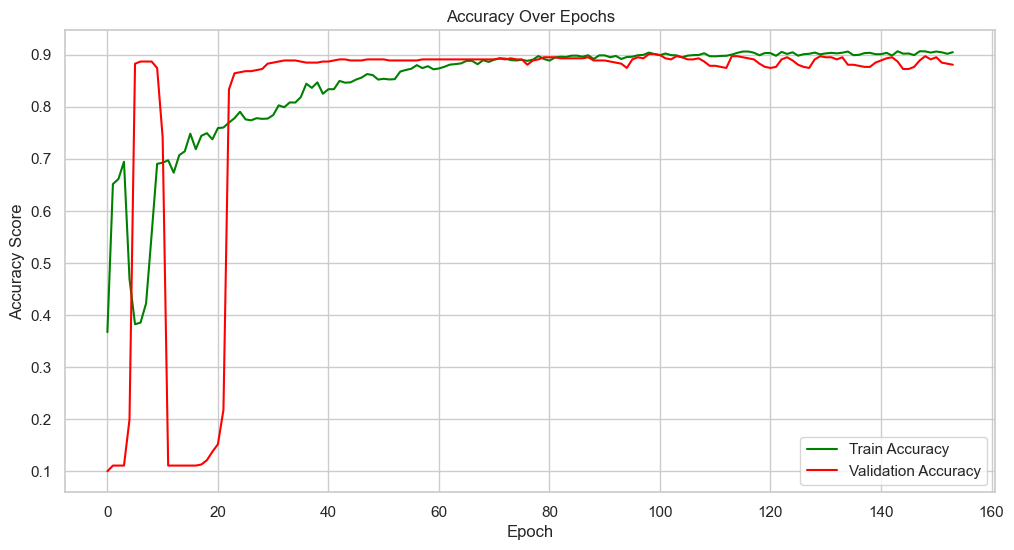

In [37]:
val_accs[0] = 0.1
plt.figure(figsize=(12, 6))
plt.plot(train_accs, label='Train Accuracy', color='green')
plt.plot(val_accs, label='Validation Accuracy', color='red')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

É preferível bloquear uma transação autêntica (Falso Positivo) do que aprovar uma transação fraudulenta (Falso Negativo).

#   roc auc 

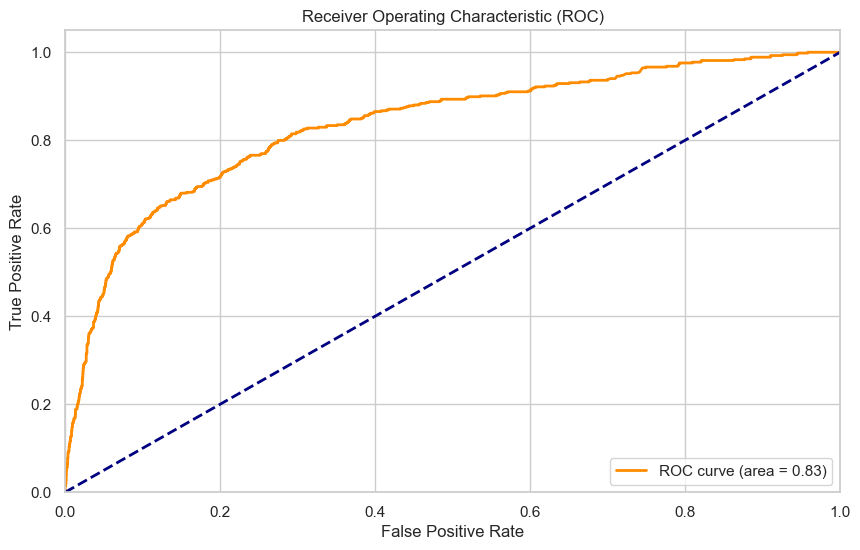

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular as probabilidades das classes
model.eval()
with torch.no_grad():
    logits = model(data.to(device))
    probs = torch.softmax(logits, dim=1)
    probs = probs.cpu().numpy()
    
# Calcular a curva ROC
fpr, tpr, _ = roc_curve(data.y.cpu().numpy(), probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()



In [35]:
# precision, recall, f1-score on test set (weighted)
model.eval()
with torch.no_grad():
    logits = model(data.to(device))
    pred = logits[test_mask].max(1)[1]
    # accuracy
    acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
    print(f'Test Accuracy: {acc:.4f}')
    print(classification_report(data.y[test_mask].cpu(), pred.cpu()))



Test Accuracy: 0.8789
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       434
           1       0.41      0.25      0.31        53

    accuracy                           0.88       487
   macro avg       0.66      0.60      0.62       487
weighted avg       0.86      0.88      0.87       487



# Tentativa de pegar nos embeddings e dar feed para um Random Forest

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4336
           1       0.53      0.25      0.33       534

    accuracy                           0.89      4870
   macro avg       0.72      0.61      0.64      4870
weighted avg       0.87      0.89      0.88      4870



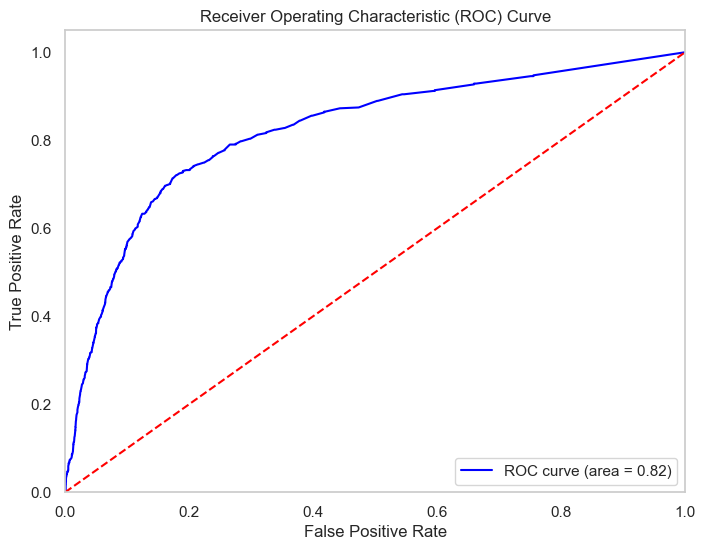

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get node embeddings and move them to CPU
node_embeddings = model.get_node_embeddings(data).cpu().numpy()
labels = data.y.cpu().numpy()

# K-Folds Cross Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

all_y_true = []
all_y_pred = []
all_y_scores = []  # Para armazenar as probabilidades de previsão

for train_index, test_index in kf.split(node_embeddings):
    X_train, X_test = node_embeddings[train_index], node_embeddings[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=200, max_depth=500, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]  # Probabilidades para a classe positiva

    # Store true and predicted values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_scores.extend(y_score)

# Generate the classification report
print(classification_report(all_y_true, all_y_pred))

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_y_true, all_y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Linha diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
